In [52]:
library(data.table)
library(ggplot2)
library(reshape2)
library(tidyverse)
source('./scripts//plottingUtils.R')
options(repr.plot.width=4, repr.plot.height=3)

In [2]:
labelColumns <- function(stat,patterns){
                    for (i in patterns){
                        if (str_detect(as.character(stat),i)){
                            return(i)
                        }}
                        return(NA)}

In [57]:
network_data_file = './all_WGS_results.csv'
ndf <- as.data.frame(fread(network_data_file),stringsAsFactors=FALSE)
genus_data_file = './all_data.tsv'
adf <- as.data.frame(fread(genus_data_file),stringsAsFactors=FALSE)
df <- merge(ndf,adf,by.x='genus',by.y='Genus',stringsAsFactors=FALSE)
#df <- df[,c('genus','Accession Number',colnames(ndf))]
#df$CRISPR.fraction <- df$ #ADD CRISPR FRACTION COLUMN
colnames(df) <- make.names(colnames(df),unique=TRUE)
print(colnames(df))
print(dim(df))

  [1] "genus"                                         
  [2] "crispr_indel_rate"                             
  [3] "crispr_indel_sem"                              
  [4] "internal_indel_rate"                           
  [5] "internal_indel_sem"                            
  [6] "non.crispr_indel_rate"                         
  [7] "non.crispr_indel_sem"                          
  [8] "taxa"                                          
  [9] "assortativity.mean"                            
 [10] "assortativity.sem"                             
 [11] "centrality.crispr_mean"                        
 [12] "centrality.crispr_sem"                         
 [13] "centrality.mw_pval"                            
 [14] "centrality.mw_stat"                            
 [15] "centrality.non.crispr_mean"                    
 [16] "centrality.non.crispr_sem"                     
 [17] "closeness_vitaltiy.crispr_mean"                
 [18] "closeness_vitaltiy.crispr_sem"                 
 [19] "clo

In [27]:
gdf <- df[,-which(colnames(df) %in% c('Accession.Number','genus.1'))] %>% distinct(genus,.keep_all=TRUE)
gdf <- melt(gdf,id.vars='genus',stringsAsFactors=FALSE)
gdf <- gdf[(!(is.na(gdf$value)))&(gdf$value!='takes_too_long'),]
gdf$value <- as.numeric(gdf$value)
gdf$StatType <- sapply(gdf$variable,labelColumns,patterns=c('mean','sem'))
gdf$CRISPR.Status <- sapply(gdf$variable,labelColumns,patterns=c('non.crispr','crispr'))
gdf$Stat <- sapply(gdf$variable,function(x) strsplit(as.character(x),'.',fixed=TRUE)[[1]][1])
gdf[c(1:2,1020:1021,550:551),]
print(unique(gdf$Stat))
print(dim(gdf))

,genus,variable,value,StatType,CRISPR.Status,Stat
1,Acetobacter,crispr_indel_rate,100.00000000,NA,crispr,crispr_indel_rate
2,Acholeplasma,crispr_indel_rate,0.05118657,NA,crispr,crispr_indel_rate
1063,Bartonella,non.crispr_indel_sem,0.13940700,sem,non.crispr,non
1064,Bdellovibrio,non.crispr_indel_sem,0.03091388,sem,non.crispr,non
569,Pseudonocardia,internal_indel_rate,2.16110600,NA,NA,internal_indel_rate
570,Pseudothermotoga,internal_indel_rate,0.62830640,NA,NA,internal_indel_rate


 [1] "crispr_indel_rate"   "crispr_indel_sem"    "internal_indel_rate"
 [4] "internal_indel_sem"  "non"                 "taxa"               
 [7] "assortativity"       "centrality"          "closeness_vitaltiy" 
[10] "clustering"          "degree"              "mean_edge_weight"   
[13] "modularity"         
[1] 7798    6


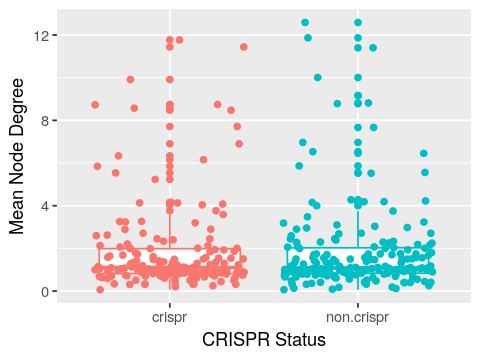

In [56]:
data <- dcast(gdf[(gdf$Stat=='degree')&(!(is.na(gdf$CRISPR.Status))),],genus + CRISPR.Status ~ StatType)
ggplot(data,aes(x=CRISPR.Status,y=mean,col=CRISPR.Status)) + 
    #geom_errorbar(aes(ymin=mean-sem,ymax=mean+sem), width=.05) +
    geom_boxplot() +
    geom_jitter() +
    ylab('Mean Node Degree') +
    xlab('CRISPR Status') +
    theme(legend.position='')